In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize 
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

# load data 

In [3]:
n_times_invert = 20

In [4]:
rx_locs = np.load("rx_locs.npy")

In [5]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [6]:
dobs = load_pre_file("dpred-fwd.txt")

In [7]:
rx_times = np.array([dobs["transmitters"][0]["receivers"][j]["time"] for j in range(len(dobs["transmitters"][0]["receivers"]))])

In [8]:
rx_times

array([0.0001    , 0.00011836, 0.00014008, 0.0001658 , 0.00019624,
       0.00023226, 0.0002749 , 0.00032536, 0.00038509, 0.00045579,
       0.00053946, 0.00063849, 0.0007557 , 0.00089443, 0.00105862,
       0.00125296, 0.00148297, 0.00175521, 0.00207742, 0.00245878])

In [9]:
n_times_invert = len(rx_times)

# create survey

In [10]:
tx_height = rx_locs[0, 2]
source_list = []

for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

full_survey = tdem.Survey(source_list)


In [11]:
dobs_values = np.zeros((n_times_invert, len(dobs["transmitters"])))
for i in range(len(dobs["transmitters"])): 
    for j in range(n_times_invert): 
        dobs_values[j, i] = dobs["transmitters"][i]["receivers"][j]["data"][-1]

In [12]:
relative_error = 0.1
noise_floor = 1e-11
observed_data = Data(survey=full_survey, dobs=-discretize.utils.mkvc(dobs_values), relative_error=relative_error, noise_floor=noise_floor)

In [13]:
ind = 25
rx_locs[ind, :]

array([ 300., -200.,   30.])

In [14]:
ubc_mesh = discretize.TreeMesh.read_UBC("octree_mesh.txt")
model = discretize.TreeMesh.read_model_UBC(ubc_mesh, "target_0.con")

In [15]:
src_ind = 90

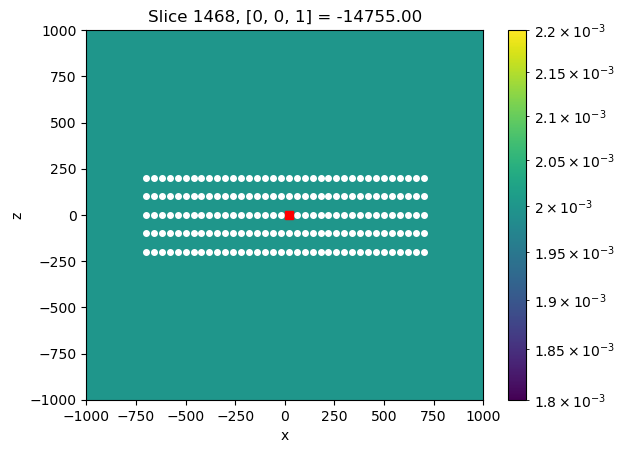

In [16]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax, pcolor_opts={"norm":LogNorm()}, 
        normal="Z", ind=1468
    )[0], 
    ax=ax
)

ax.set_xlim(1000*np.r_[-1, 1])
ax.set_ylim(1000*np.r_[-1, 1])

ax.plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)
ax.plot(rx_locs[src_ind, 0], rx_locs[src_ind, 1], "rs", ms=6)

In [17]:
observed_data[src, src.receiver_list[0]]

array([-3.464468e-09, -2.325646e-09, -1.529475e-09, -1.052343e-09,
       -7.139420e-10, -4.806080e-10, -3.221612e-10, -2.149543e-10,
       -1.429087e-10, -9.180024e-11, -6.201548e-11, -4.162420e-11,
       -2.768266e-11, -1.834065e-11, -1.197157e-11, -7.877901e-12,
       -5.315422e-12, -3.547845e-12, -2.352372e-12, -1.552060e-12])

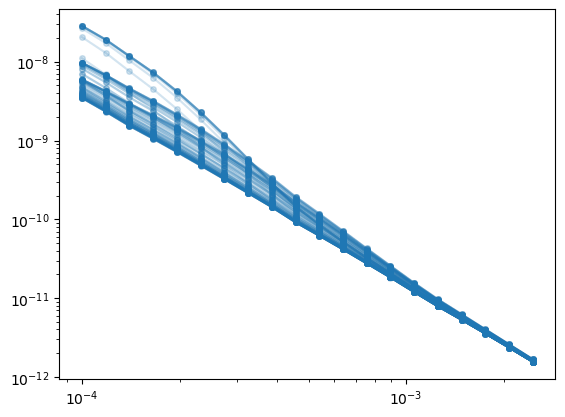

In [18]:
for src_ind in range(180): 
    src = full_survey.source_list[src_ind]
    
    # plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
    plt.loglog(rx_times, -observed_data[src, src.receiver_list[0]], "C0-o", ms=4, alpha=0.1)

In [57]:
thicknesses_true = np.r_[40, 40]
sigma_true = 1./np.r_[500, 20, 500]

In [58]:
src_ind = 90
source_sounding = full_survey.source_list[src_ind]
survey_sounding = tdem.Survey([source_sounding])
sim1d_true = tdem.Simulation1DLayered(
    survey=survey_sounding, thicknesses=thicknesses_true, sigmaMap=maps.IdentityMap(nP=3)
)

In [61]:
dpred_halfspace = sim1d_true.dpred(1./500*np.ones(3))

In [62]:
dpred_1d = sim1d_true.dpred(sigma_true)

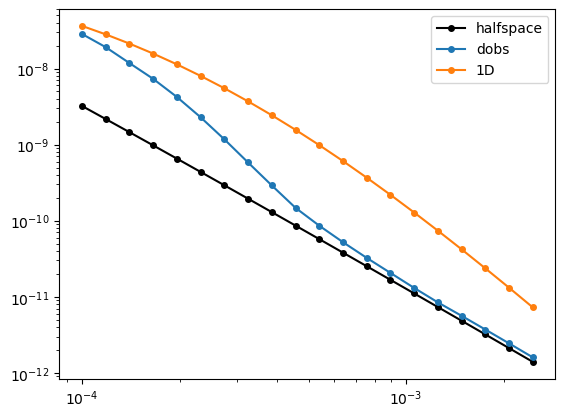

In [66]:
fig, ax = plt.subplots(1, 1)

ax.loglog(rx_times, -dpred_halfspace, "k-o", ms=4, label="halfspace")
ax.loglog(rx_times, -observed_data[source_sounding, source_sounding.receiver_list[0]], "C0-o", ms=4, label="dobs")
ax.loglog(rx_times, -dpred_1d, "C1-o", ms=4, label="1D")

ax.legend()

In [23]:
# octree_mesh = discretize.load_mesh("./synthetic-data/treemesh.json")

# octree_mesh = discretize.load_mesh()

In [24]:
cs = 5
core_region = 200
npad = 20
padding_factor = 1.3

thicknesses1d = discretize.utils.unpack_widths(
    [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
)

In [25]:
np.sum(thicknesses1d)


np.float64(4296.075484557508)

In [110]:
# set up 1D inversion 
def create_inversion(
    ind,
    relative_error=0.1,
    noise_floor=1e-11,
    alpha_s = 1e-3,
    alpha_x = 1,
    rho_back = 500,
    beta0 = 5,
): 
    
    rx_times_invert = rx_times[:n_times_invert]
    
    # def create inv
    # src = full_survey.source_list[ind]
    # rx = src.receiver_list[0]
    
    rx_sounding = tdem.receivers.PointMagneticFluxTimeDerivative(
        locations=rx_locs[ind, :], times=rx_times_invert, orientation="z"
    )
    src_sounding = tdem.sources.CircularLoop(
        receiver_list=[rx_sounding], location=rx_locs[ind, :], orientation="z", 
        radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    survey_sounding = tdem.Survey([src_sounding])
    mesh_invert = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")
    
    sim1d = tdem.Simulation1DLayered(
        survey=survey_sounding, thicknesses=thicknesses1d, sigmaMap=maps.ExpMap(mesh_invert)
    )

    source_sounding = full_survey.source_list[ind]
    data_invert = Data(
        survey_sounding, 
        dobs=observed_data[source_sounding, source_sounding.receiver_list[0]],
        relative_error=relative_error,
        noise_floor=noise_floor
    )
    
    dmis = data_misfit.L2DataMisfit(simulation=sim1d, data=data_invert)
    reg = regularization.WeightedLeastSquares(
        mesh_invert, alpha_s=alpha_s, alpha_x=alpha_x, 
        # reference_model=np.log(1./rho_back),
        # norms=norms
    )
    
    opt = optimization.InexactGaussNewton(maxIter=10)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=beta0)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
    
    cool_beta = directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    
    # Update the preconditionner
    update_Jacobi = directives.UpdatePreconditioner()
    
    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputDictEveryIteration(
        saveOnDisk=False, name=f"inv-dict-{rx.locations[0,0]}"
    )
    
    
    # Updating the preconditionner if it is model dependent.
    update_jacobi = directives.UpdatePreconditioner()
    
    # Add sensitivity weights
    sensitivity_weights = directives.UpdateSensitivityWeights()
    
    target_misfit = directives.TargetMisfit()
    
    # The directives are defined as a list.
    directives_list = [
        # sensitivity_weights,
        # update_jacobi,
        starting_beta,
        cool_beta,
        save_iteration,
        target_misfit,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    return inv

In [111]:
ind = 90
inv = create_inversion(ind)

In [112]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
mopt = inv.run(m0)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.02e+01  5.91e+02  0.00e+00  5.91e+02    6.89e+01      0              
   1  4.01e+01  3.28e+02  7.47e-02  3.31e+02    1.02e+02      2              
   2  2.67e+01  1.59e+02  2.23e-01  1.65e+02    7.24e+01      2              
   3  1.78e+01  1.06e+02  3.53e-01  1.12e+02    5.77e+01      

In [113]:
iterations = len(inv.directiveList.dList[-2].outDict)

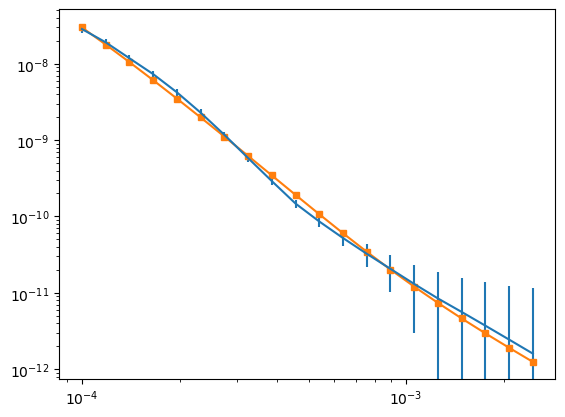

In [114]:

# plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
# plt.loglog(rx_times, -data_dict[key][src, rx], "C0o", ms=4)
rx_times_invert = rx_times[:n_times_invert]
plt.errorbar(rx_times_invert, -inv.invProb.dmisfit[0][1].data.dobs, yerr=inv.invProb.dmisfit[0][1].data.standard_deviation)
plt.loglog(rx_times_invert, -inv.directiveList.dList[-2].outDict[iterations]["dpred"], "C1-s", ms=4)

(0.0001, 0.1)

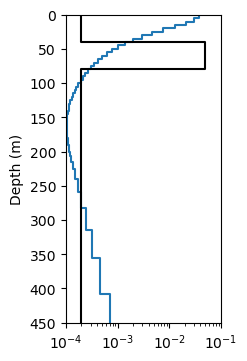

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
)
plot_1d_layer_model(
    thicknesses_true, sigma_true, ax=ax, color="k", label="true"
)
ax.set_ylim([450, 0])
ax.set_xlim([1e-4, 1e-1])


In [15]:
# directory = "./synthetic-invs-1d-fixed-beta"

In [16]:
# def run_inv(key, ind, dobs): 
#     inv = create_inversion(key, ind, dobs)
#     rho_start = 500
#     m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
    
#     label_key=f"{key}_{ind}"
    
#     mopt = inv.run(m0)
#     np.save(f"{directory}/{label_key}_model.npy", mopt)
    
#     inv_dict = inv.directiveList.dList[-2].outDict
#     with open(f"{directory}/{label_key}_inv_dict.pkl", "wb") as f:
#         pickle.dump(inv_dict, f)

#     return label_key, mopt


In [17]:
# key = "target_0"
# n_times_invert = 20
# ind = 25
# src = full_survey.source_list[ind]
# rx = src.receiver_list[0]
# dobs = data_dict[key][src, rx][:n_times_invert]

# inv = create_inversion(key, ind, dobs)

In [18]:
# rho_start = 500
# m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
# mopt = inv.run(m0)
    


In [21]:

# rho_back = 500
# sigma_back = 1./rho_back 

# rho_target = 20
# sigma_target = 1./rho_target
# target_z_center = -60
# target_thickness = 40

# model_true = np.log(1/np.r_[rho_back, rho_target, rho_back])

# thicknesses_true = np.r_[-target_z_center - target_thickness/2, target_thickness]

In [23]:
model_keys = list(data_dict.keys())[1:]
model_keys

['target_30', 'target_45', 'target_0', 'target_15']

In [24]:
rx_locs.shape

(51, 3)

In [25]:
inv_dict = {}
n_times_invert = 20

# key = model_keys[0]
with ProcessPoolExecutor() as executor:
    futures = []
    for key in model_keys: 
        for ind in range(rx_locs.shape[0]): 
            src = full_survey.source_list[ind]
            rx = src.receiver_list[0]
            dobs = data_dict[key][src, rx][:n_times_invert]
            futures.append(
                executor.submit(run_inv, key, ind, dobs)
            )
            
    for future in as_completed(futures):
        label_key, mopt = future.result()
        inv_dict[label_key] = mopt


Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0

Running inversion with SimPEG v0.24.0

Running inversion with SimPEG v0.24.0




Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
Running inversion with SimPEG v0.24.0

simpeg.InvProblem will set Regularization.reference_model to m0.
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0
Running inversion with SimPEG v0.24.0

simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.simpeg.InvProblem will set Regularization.reference_model to m0.simpeg.InvProblem will set Regularization.reference_model to m0.
Running inversion with SimPEG v0.

In [26]:
target_0_keys = [k for k in inv_dict.keys() if "target_0" in k]

In [27]:
recovered_models = {}

for k in model_keys:
    recovered_models[k] = np.vstack([
        inv_dict[f"{k}_{ind}"] for ind in range(rx_locs.shape[0])
    ]).T

In [28]:
mesh_invert = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")


In [5]:
with open("./synthetic-data/true-models.pkl", "rb") as f:
    true_models = pickle.load(f)

In [6]:
tree_mesh = discretize.load_mesh("./synthetic-data/treemesh.json")

/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/utils/io_utils.py:39: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  data = cls(**jsondict)


In [7]:
tree_mesh

OcTreeMesh,0.01% filled
Level,Number of cells
3,448
4,392
5,624
6,1568
7,2772
8,43744
9,42516
10,28512
Total,120576


In [8]:
key = "target_45"

NameError: name 'rx_locs' is not defined

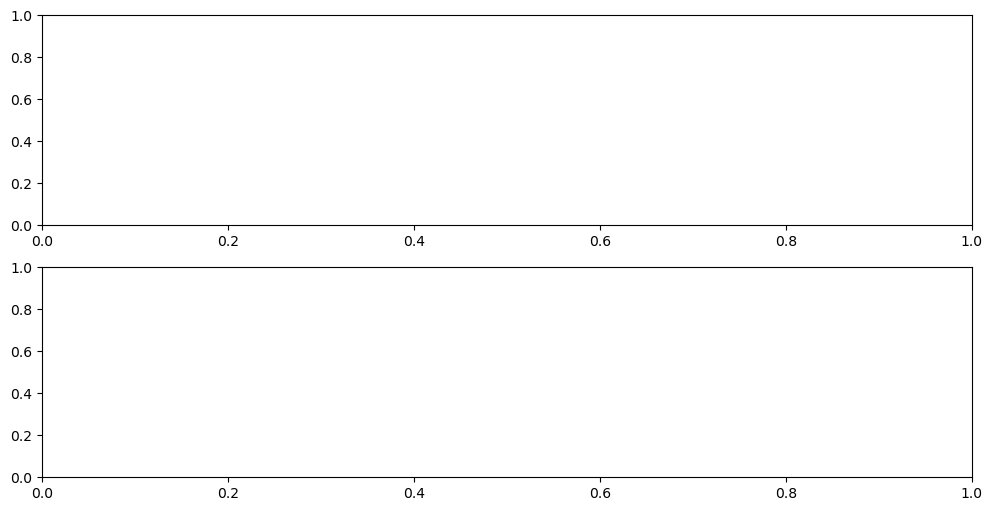

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

norm = LogNorm(vmin=1e-3, vmax=1/20)

plt.colorbar(ax[0].pcolor(
    rx_locs[:, 0], -mesh_invert.cell_centers, np.exp(recovered_models[key]), norm=norm
), ax=ax[0])

plt.colorbar(
    tree_mesh.plot_slice(
        true_models[key], pcolor_opts={"norm":norm}, ax=ax[1],
        normal="y"
    )[0], ax=ax[1]
)

for a in ax: 
    a.set_ylim(np.r_[-250, 0])
    a.set_xlim(np.r_[-500, 500])
    a.set_aspect(1)